In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import seaborn as sns

import os

from PlottingScripts import CV, Spline, Tune1, distVar, distplot_wratio, StackedHisto, SimpleHisto, mcplot

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Welcome to JupyROOT 6.18/04


In [2]:
orthogonalcut = 'MaxShrFrac < .2'
precuts ='ChargeNearTrunk > 0 and FailedBoost != 1 and OpenAng > .5'# and  and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15'
emptycut = 'Enu_1m1p > 0'

precut = orthogonalcut + ' and ' + precuts

totalscale = 5e19


f_scaleslist = []
s_detsyslist = []

s_detsyslist.append('wiremodX')
f_scaleslist.append(9.57329064772e+19) #POT

s_detsyslist.append('wiremodYZ')
f_scaleslist.append(9.47300763323e+19) #POT

s_detsyslist.append('wiremoddEdx')
f_scaleslist.append(1.1091115051e+20)

s_detsyslist.append('LYdown')
f_scaleslist.append(1.01577606567e+20)

#s_detsyslist.append('LYattenuation')
#f_scaleslist.append(1.09661060344e+20)

s_detsyslist.append('SCE')
f_scaleslist.append(7.18768474771e+19)

s_detsyslist.append('wiremodThetaYZ')
f_scaleslist.append(9.17621782665e+19)

s_detsyslist.append('wiremodThetaXZ')
f_scaleslist.append(8.95024851469e+19)

#s_detsyslist.append('recomb')
#f_scaleslist.append(7.26515325677e+19)

df_cv = pd.read_parquet('../../data/pickles/detsys_CV_run3_nodupesMay1.parquet')
scaleCV = 9.65858292241e+19 

a_df_sys = []

RSE = ['run','subrun','event']


for sys in s_detsyslist:
    df_sys = pd.read_parquet('../../data/pickles/detsys_%s_run3_nodupesMay1.parquet'%sys)
    df_sys = df_sys.join(df_cv.set_index(RSE),on=RSE,rsuffix='_cv')
    a_df_sys.append(df_sys)

df_numu_run3_presel = pd.read_parquet('../../data/pickles/numu_run1_nodupesMay1.parquet')

In [6]:
# Make big list of variables with their accompanying ranges so we can just dump a buttload of plots
varlistSel = []

varlistSel.append(distVar('Xreco',(15,241.25),'Reco Vertex X')
varlistSel.append(distVar('Yreco',(-101.5,101.5),'Reco Vertex Y')
varlistSel.append(distVar('Zreco',(15,1021.8),'Reco Vertex Z')
varlistSel.append(distVar('OpenAng',(.6,2.8),'Opening Angle (rads)')
varlistSel.append(distVar('Thetas',(0,2*np.pi),r'Sum of Thetas ($\theta_{p} + \theta_{\mu}$) (rads)')
varlistSel.append(distVar('Phis',(0,2*np.pi),r'Sum of Phis ($\phi_{p} + \phi_{\mu}$)  (rads)')
varlistSel.append(distVar('ChargeNearTrunk',(0,800),'ADC Charge within 5cm of Reco Vertex')
varlistSel.append(distVar('Enu_1m1p',(300,1200),'Reconstructed Neutrino Energy (MeV)')
varlistSel.append(distVar('PhiT_1m1p',(0,1),r'$\phi_T$')
varlistSel.append(distVar('AlphaT_1m1p',(0,np.pi),r'$\alpha_T$')
varlistSel.append(distVar('PT_1m1p',(0,400),r'$p_T$')
varlistSel.append(distVar('PTRat_1m1p',(0,.4),r'$p_T/|p|$')
varlistSel.append(distVar('BjX_1m1p',(0,2),'Bjorken X')
varlistSel.append(distVar('BjY_1m1p',(0,.8),'Bjorken Y')
varlistSel.append(distVar('Q2_1m1p',(0,6e5),r'$Q^2$')
varlistSel.append(distVar('Sph_1m1p',(0,1000),'QE Consistency')
varlistSel.append(distVar('PzEnu_1m1p',(-300,400),r'$p_z - E_\nu$ (MeV)'))
varlistSel.append(distVar('Q0_1m1p',(70,600),r'$Q_0$')
varlistSel.append(distVar('Q3_1m1p',(50,1000),r'$Q_3$')
varlistSel.append(distVar('Lepton_PhiReco',(-np.pi,np.pi),r'Muon $\phi$')
varlistSel.append(distVar('Lepton_ThetaReco',(0,np.pi),r'Muon $\theta$')
varlistSel.append(distVar('Lepton_TrackLength',(5,200),'Muon Track Length (cm)')
varlistSel.append(distVar('Muon_Edep',(20,600),'Reco Muon Energy (from range) (MeV)')
varlistSel.append(distVar('Proton_PhiReco',(-np.pi,np.pi),r'Proton $\phi$')
varlistSel.append(distVar('Proton_ThetaReco',(0,np.pi),r'Proton $\theta$')
varlistSel.append(distVar('Proton_TrackLength',(5,150),'Proton Track Length')
varlistSel.append(distVar('Proton_Edep',(50,500),'Reco Proton Energy (from range) (MeV)')

In [39]:
#add experimental weights
with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweights_1m1p_run3_lowe_may13vars.pickle','rb') as handle: bdt_run3_cosmic,bdt_run3_nu = pickle.load(handle)          # Load BDT weights for 1mu1p background differentiation
    
vars_may13 = ['OpenAng','Phis','ChargeNearTrunk','Enu_1m1p','PhiT_1m1p','AlphaT_1m1p','PT_1m1p','PTRat_1m1p','BjX_1m1p','BjY_1m1p','Sph_1m1p','Q0_1m1p','Q3_1m1p','Lepton_PhiReco','Lepton_TrackLength','Proton_PhiReco','Proton_ThetaReco']

myvars = vars_may13

In [40]:
for df in a_df_sys:
    df.insert(0,'bdt_run3_cosmic',bdt_run3_cosmic.predict_proba(df[myvars].values.tolist())[:,0])
    df.insert(0,'bdt_run3_nu',bdt_run3_nu.predict_proba(df[myvars].values.tolist())[:,0])


df_numu_run3_presel.insert(0,'bdt_run3_cosmic',bdt_run3_cosmic.predict_proba(df_numu_run3_presel[myvars].values.tolist())[:,0])
df_numu_run3_presel.insert(0,'bdt_run3_nu',bdt_run3_nu.predict_proba(df_numu_run3_presel[myvars].values.tolist())[:,0])
       
df_cv.insert(0,'bdt_run3_cosmic',bdt_run3_cosmic.predict_proba(df_cv[myvars].values.tolist())[:,0])
df_cv.insert(0,'bdt_run3_nu',bdt_run3_nu.predict_proba(df_cv[myvars].values.tolist())[:,0])
    

In [87]:
dumpbins = 18
dumphole = '/home/dcianci/Downloads/detsys_may18_sel' # where are we dumping these?

bdtcuts = 'bdt_run3_cosmic < .5 and bdt_run3_nu < .5'

emptycut = 'Enu_1m1p > 0'
morecuts = 'Enu_1m1p < 1000'#Lepton_CosTheta < .9'

s_cuts = precuts + ' and ' + bdtcuts + ' and ' + morecuts

if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlist:
    
    fig,ax = plt.subplots(figsize=(16,11))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    hSys =  []
    
    for i in range(len(s_detsyslist)):
        var_sys = a_df_sys[i].query(s_cuts)[dist.myname]
        sys_scale = np.ones(len(var_sys))*totalscale/f_scaleslist[i]
        h0,_ = np.histogram(var_sys,range=dist.myrange,bins=dumpbins,weights=sys_scale)
        h1,_,_ = ax0.hist(var_sys,range=dist.myrange,bins=dumpbins,histtype='step',label=s_detsyslist[i]+' (%i)'%h0.sum(),linewidth=2,weights=sys_scale)
        hSys.append(h1)
    
    var_cv = df_cv.query(s_cuts)[dist.myname]
    cv_scale = np.ones(len(var_cv))*totalscale/scaleCV
    h0,_ = np.histogram(var_cv,range=dist.myrange,bins=dumpbins,weights=cv_scale)
    hCV,binedges,_ = ax0.hist(var_cv,range=dist.myrange,bins=dumpbins,histtype='step',label='CV (%i)'%h0.sum(),linewidth=3,color='black',linestyle='--',weights=cv_scale)       
    
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax0.set_xlabel(dist.mylabel,fontsize=25)
    ax0.set_title('BNB Overlay w/ Detsys',fontsize=15)
    ax0.set_xlim(dist.myrange)
    ax1.set_xlim(dist.myrange)
    ax1.set_ylim(0,2.5)
    ax0.legend(fontsize=15)
    
    for i in range(len(hSys)):
        ydots = np.true_divide(hSys[i],hCV,where=hCV!=0)
        xdots = binedges[:-1] + (binedges[1]-binedges[0])/float(len(hSys)) * i
        ax1.scatter(xdots,ydots)
    
    ax1.axhline(1,linestyle=':',color='maroon')
    
    for j in range(len(hCV)):
        ax1.axvline(binedges[j+1],linestyle=':',color='gray') 
    
    plt.savefig(dumphole+'/'+dist.myname+'.png')
    plt.close(fig)

# Build Covariance Matrices!

In [59]:
bdtcuts = 'bdt_run3_cosmic < .5 and bdt_run3_nu < .5'
emptycut = 'Enu_1m1p > 0'
morecuts = 'Enu_1m1p < 1000'#Lepton_CosTheta < .9'

s_cuts = precut + ' and ' + bdtcuts + ' and ' + morecuts

nbins = 18


if not os.path.exists('DetSysCov'):
    os.makedirs('DetSysCov')

for dist in varlistSel:

    cov = np.zeros((nbins,nbins))

    for sysi in range(len(a_df_sys)):
        myvardf = a_df_sys[sysi].query('Enu_1m1p > 0 and Enu_1m1p_cv > 0')
        
        var_sys = myvardf.query(s_cuts)[dist.myname]
        var_cv = myvardf.query(s_cuts)[dist.myname+'_cv']
        #cv_scale = np.ones(len(var_cv))*totalscale/scaleCV
        #sys_scale = np.ones(len(var_sys))*totalscale/f_scaleslist[sysi]

        hCV,binedges = np.histogram(var_cv,bins=nbins,range=dist.myrange)#,weights=cv_scale)
        h0,_ = np.histogram(var_sys,bins=nbins,range=dist.myrange)#,weights=cv_scale)
        
        #fig,ax = plt.subplots(figsize=(16,11))
        #_ = plt.hist(var_cv,bins=nbins,range=dist.myrange)
        #_ = plt.hist(var_sys,bins=nbins,range=dist.myrange)
                
        for i in range(nbins):
            for j in range(nbins):
                if hCV[i] > 0 and hCV[j] > 0:
                    cov[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])
                elif h0[i] > 0 and h0[j] > 0:
                    cov[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(h0[i]*h0[j])
        
    np.savetxt('DetSysCov/detsys_%s_cov.csv'%dist.myname, cov, delimiter=',')

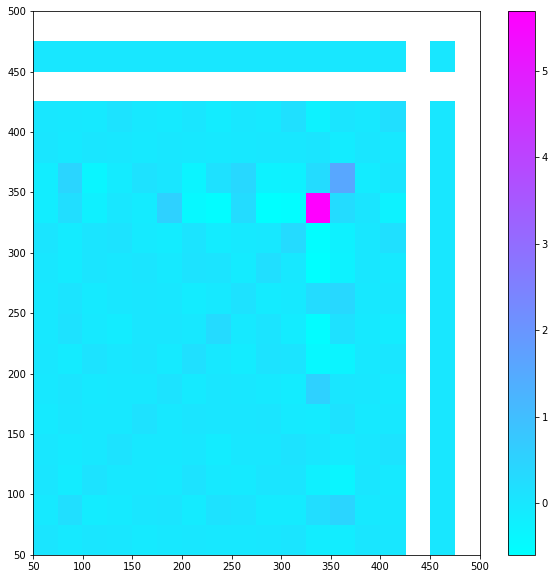

In [46]:
X, Y = np.meshgrid(binedges,binedges)

fig,ax = plt.subplots(figsize=(10,10))
crat = ax.pcolormesh(X, Y,cov,cmap='cool')#,vmin=-2,vmax=3)
cbar = fig.colorbar(crat)


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in long_scalars
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


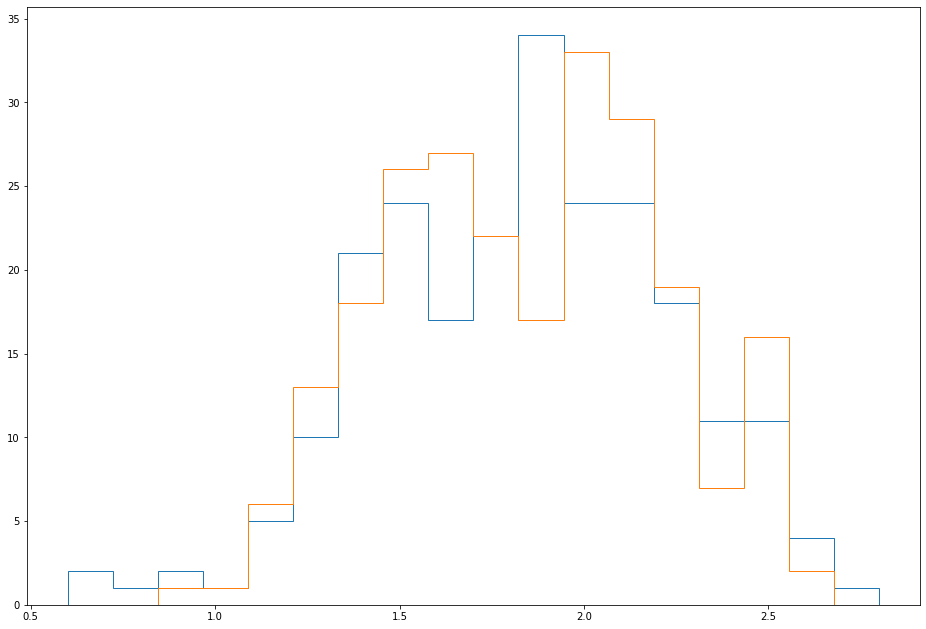

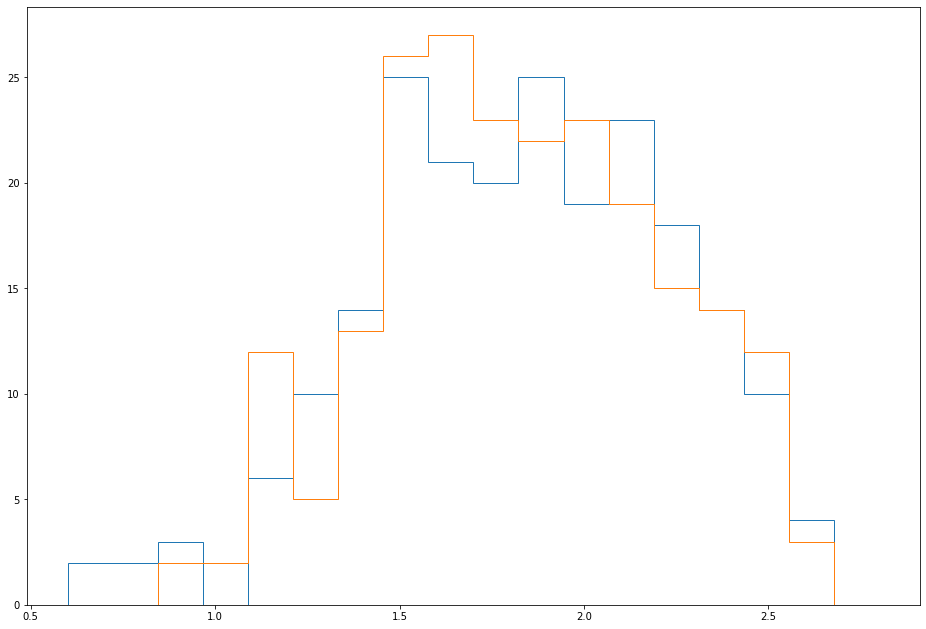

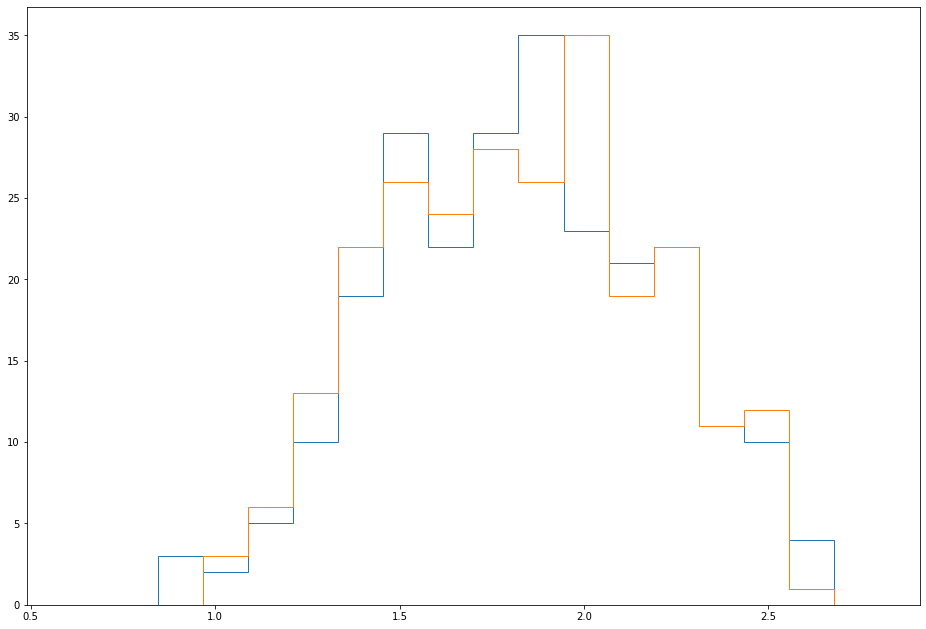

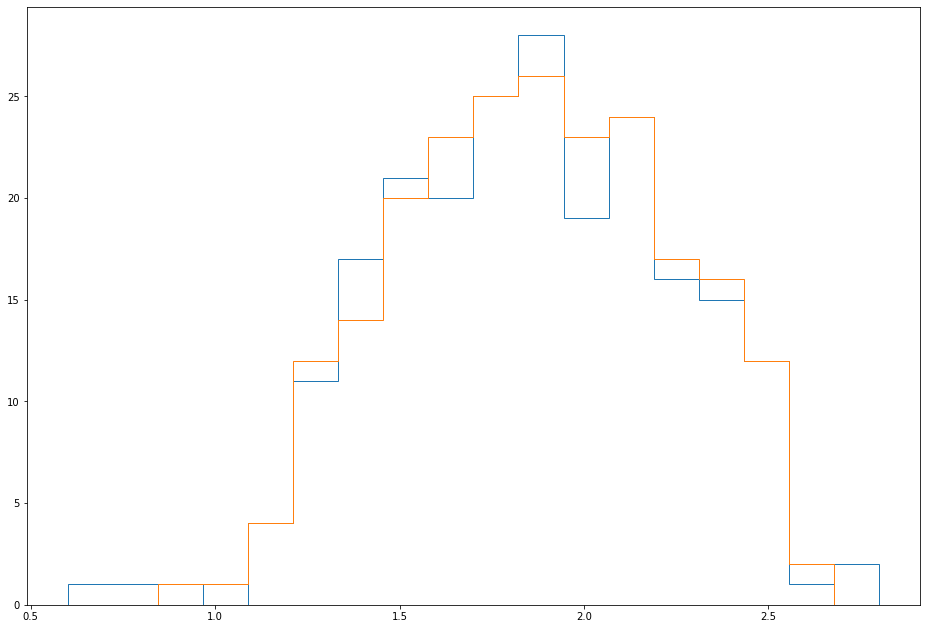

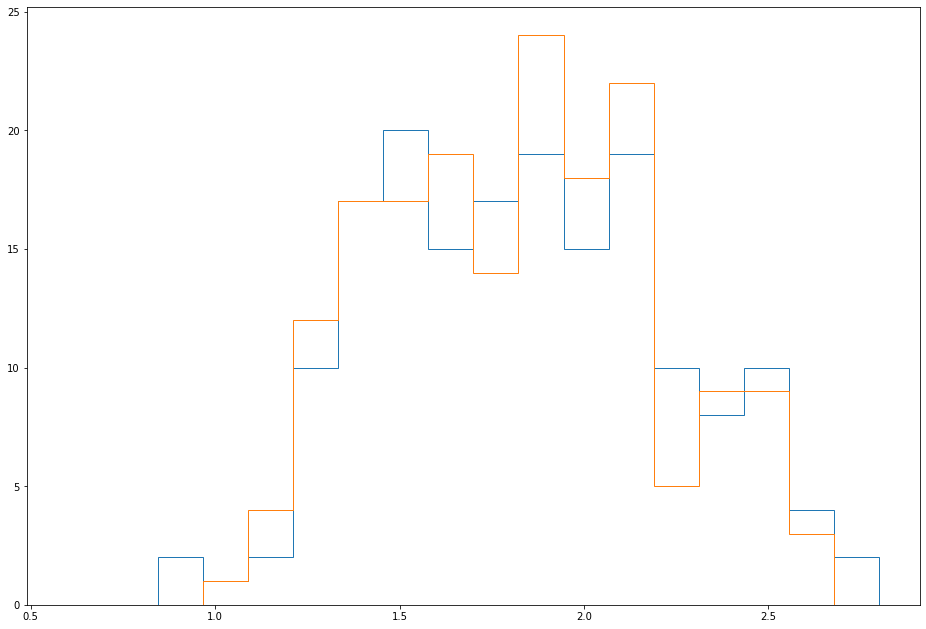

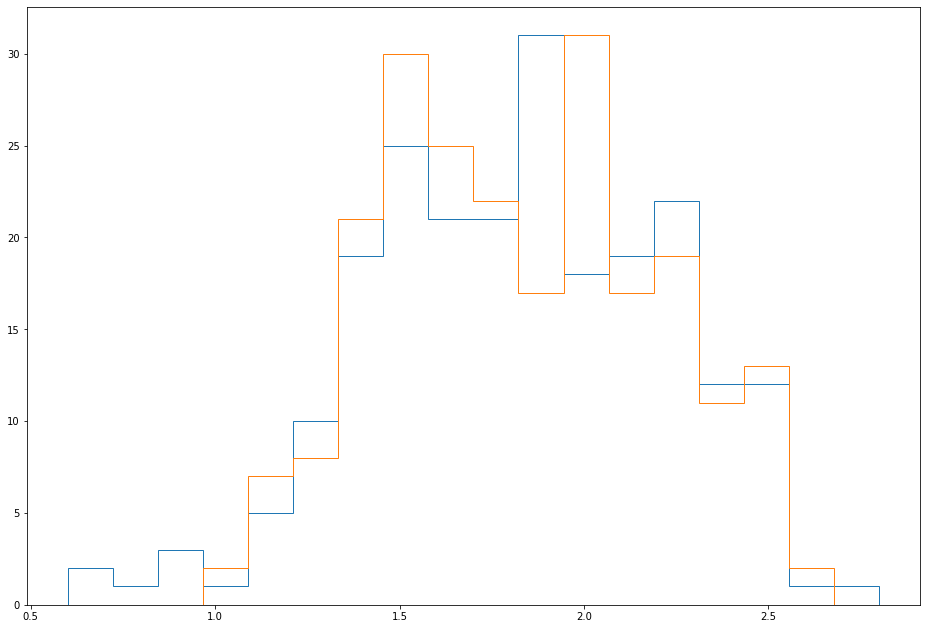

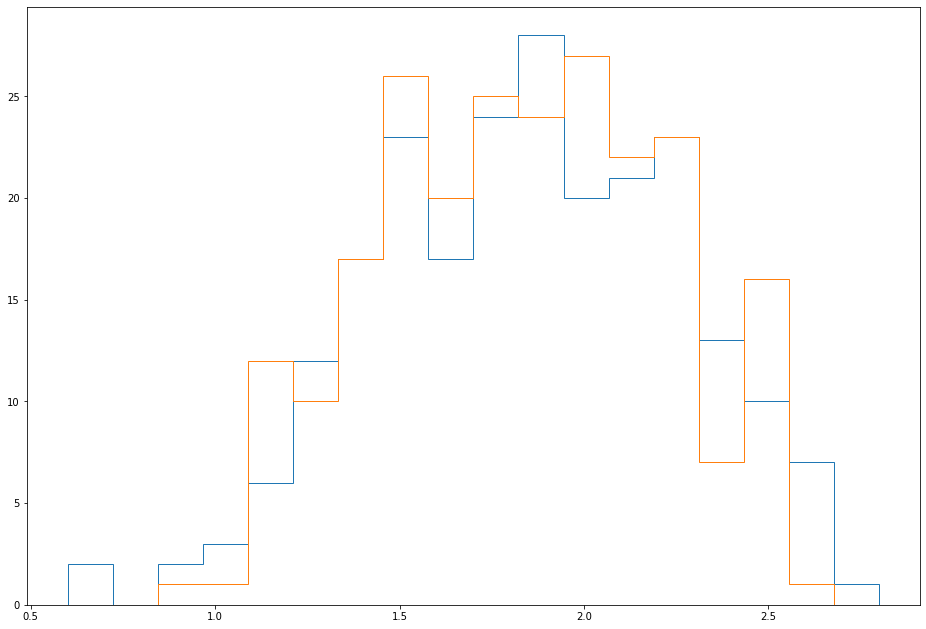

In [55]:
dist = varlistSel[3]

cov = np.zeros((nbins,nbins))

for sysi in range(len(a_df_sys)):
    myvardf = a_df_sys[sysi].query('Enu_1m1p > 0 and Enu_1m1p_cv > 0')
        
    var_sys = myvardf.query(s_cuts)[dist.myname]
    var_cv = myvardf.query(s_cuts)[dist.myname+'_cv']
    #cv_scale = np.ones(len(var_cv))*totalscale/scaleCV
    #sys_scale = np.ones(len(var_sys))*totalscale/f_scaleslist[sysi]

    hCV,binedges = np.histogram(var_cv,bins=nbins,range=dist.myrange)#,weights=cv_scale)
    h0,_ = np.histogram(var_sys,bins=nbins,range=dist.myrange)#,weights=cv_scale)
        
    fig,ax = plt.subplots(figsize=(16,11))
    _ = plt.hist(var_cv,bins=nbins,range=dist.myrange,histtype='step')
    _ = plt.hist(var_sys,bins=nbins,range=dist.myrange,histtype='step')
                
    for i in range(nbins):
        for j in range(nbins):
            cov[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])

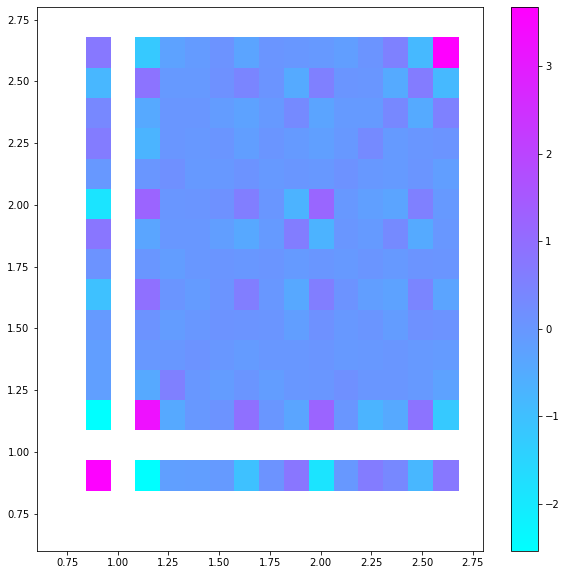

In [57]:
def DrawMatrix(cov,nbins)


X, Y = np.meshgrid(binedges,binedges)

fig,ax = plt.subplots(figsize=(10,10))
crat = ax.pcolormesh(X, Y,cov,cmap='cool')#,vmin=-2,vmax=3)
cbar = fig.colorbar(crat)


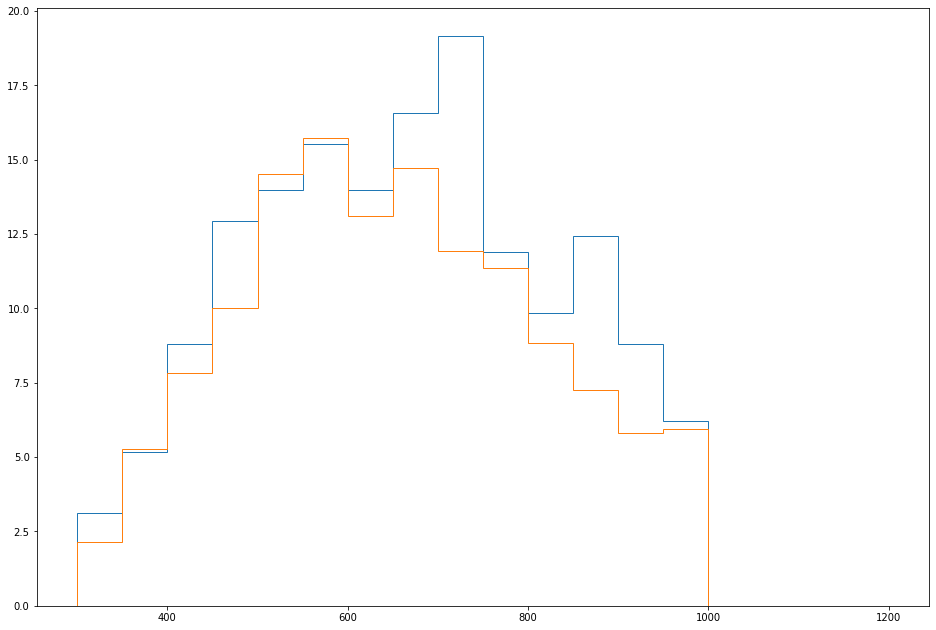

In [75]:
vartest = 'Enu_1m1p'
myrange = (300,1200)
mybins = 18

var_cv = df_cv.query(s_cuts)[vartest]
cv_scale = np.ones(len(var_cv))*totalscale/scaleCV

scalebnb = 8.98773223801e+20

var_bnb = df_numu_run3_presel.query(s_cuts)[vartest]
bnb_scale = df_numu_run3_presel.query(s_cuts)['xsec_corr_weight']*totalscale/scalebnb


fig,ax = plt.subplots(figsize=(16,11))
_ = plt.hist(var_cv,bins=nbins,range=myrange,weights=cv_scale,histtype='step')
_ = plt.hist(var_bnb,bins=nbins,range=myrange,weights= bnb_scale,histtype='step')


## Extras

In [83]:
dumpbins = 18
dumphole = '/home/dcianci/Downloads/detsys_may18_presel' # where are we dumping these?

if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlistSel:
    
    fig,ax = plt.subplots(figsize=(16,11))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    hSys =  []
    
    for i in range(len(s_detsyslist)):
        var_sys = a_df_sys[i][dist.myname]
        sys_scale = np.ones(len(var_sys))*totalscale/f_scaleslist[i]
        h0,_ = np.histogram(var_sys,range=dist.myrange,bins=dumpbins,weights=sys_scale)
        h1,_,_ = ax0.hist(var_sys,range=dist.myrange,bins=dumpbins,histtype='step',label=s_detsyslist[i]+' (%.4f)'%h0.sum(),linewidth=2,weights=sys_scale)
        hSys.append(h1)
    
    var_cv = df_cv[dist.myname]
    cv_scale = np.ones(len(var_cv))*totalscale/scaleCV
    h0,_ = np.histogram(var_cv,range=dist.myrange,bins=dumpbins,weights=cv_scale)
    hCV,binedges,_ = ax0.hist(var_cv,range=dist.myrange,bins=dumpbins,histtype='step',label='CV (%.4f)'%h0.sum(),linewidth=3,color='black',linestyle='--',weights=cv_scale)
    
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax0.set_xlabel(dist.mylabel,fontsize=25)
    ax0.set_title('BNB Overlay w/ Detsys',fontsize=15)
    ax0.set_xlim(dist.myrange)
    ax1.set_xlim(dist.myrange)
    ax0.legend(fontsize=15)
    ax1.set_ylim(0,2.5)
    
    for i in range(len(hSys)):
        ydots = np.true_divide(hSys[i],hCV,where=hCV!=0)
        xdots = binedges[:-1] + (binedges[1]-binedges[0])/float(len(hSys)) * i
        ax1.scatter(xdots,ydots)
    
    ax1.axhline(1,linestyle=':',color='maroon')
    
    for j in range(len(hCV)):
        ax1.axvline(binedges[j+1],linestyle=':',color='gray') 
    
    plt.savefig(dumphole+'/'+dist.myname+'.png')
    plt.close(fig)

/home/dcianci/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/dcianci/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
